# Data preprocessing and augmentations

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pywt
from google.colab.patches import cv2_imshow
import math
import tensorflow
import tensorflow as tf
import glob
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import keras
from keras.models import Model, load_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import concatenate
from keras.layers import Input, BatchNormalization, Activation, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam


In [ ]:
#Reference: https://pynative.com/python-glob#:~:text=The%20glob%20module%2C%20part%20of,Unix%20Shell%20path%20expansion%20rules
names=[]
#Making an array for the names of all the images in the training set
for img in glob.glob("/content/drive/MyDrive/ee610_ass1/Tissue-Images/*.png"):
  #Glob returns paths of images of the folder in a randomised order
  names.append(img[48:71])
  #Extracting and appending the names to the array from the file paths
print(len(names))
#Size of train dataset


30


In [ ]:
#Lists to store the train images, black and white masks and coloured masks
ImagesTrain=[]
BWMTrain=[]
CMTrain=[]
#Reading the corresponding names of images from the different drive folders and appending them to the required folders
for i in range(30):
    a=cv2.imread("/content/drive/MyDrive/ee610_ass1/Tissue-Images/"+names[i]+".png")
    ImagesTrain.append(a)
    a=cv2.imread("/content/drive/MyDrive/ee610_ass1/Binary-Mask/"+names[i]+".png")
    BWMTrain.append(a)
    a=cv2.imread("/content/drive/MyDrive/ee610_ass1/Color-Mask/"+names[i]+".png")
    CMTrain.append(a)

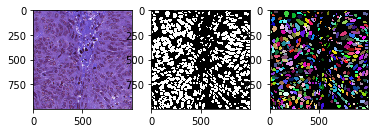

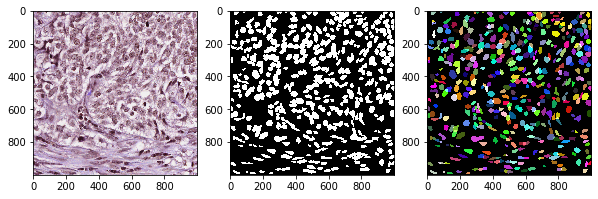

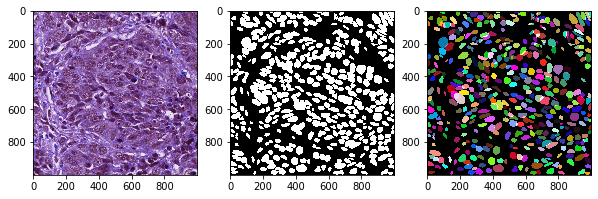

In [ ]:
#Using matplotlib subplots to plot in a table
for i in range (3):
    Image,Blackwhite,Color = ImagesTrain[i], BWMTrain[i],CMTrain[i]
    fig,d =  plt.subplots(1,3)
    plt.rcParams["figure.figsize"] = (10,10)

    d[0].imshow(Image, interpolation='nearest')
    d[0].plot()

    d[1].imshow(Blackwhite, interpolation='nearest')
    d[1].plot()

    d[2].imshow(Color, interpolation='nearest')
    d[2].plot()
 #We have plotted the train image, its corresponding black and white and coloured masks here
 #Reference: https://www.w3schools.com/python/matplotlib_subplot.asp

In [ ]:
#Reference: https://pynative.com/python-glob#:~:text=The%20glob%20module%2C%20part%20of,Unix%20Shell%20path%20expansion%20rules
names=[]
#Making an array for the names of all the images in the testing set
for img in glob.glob("/content/drive/MyDrive/ee610_ass1/test/Tissue-Images/*.png"):
  #Glob returns paths of images of the folder in a randomised order
  names.append(img[53:76])
  #Extracting and appending the names to the array from the file paths
print(len(names))
#Size of test dataset

14


In [ ]:
#Lists to store the test images, black and white masks and coloured masks
ImagesTest=[]
BWMTest=[]
CMTest=[]
#Reading the corresponding names of images from the different drive folders and appending them to the required folders
for i in range(14):
    a=cv2.imread("/content/drive/MyDrive/ee610_ass1/test/Tissue-Images/"+names[i]+".png")
    ImagesTest.append(a)
    a=cv2.imread("/content/drive/MyDrive/ee610_ass1/test/Binary-Mask/"+names[i]+".png")
    BWMTest.append(a)
    a=cv2.imread("/content/drive/MyDrive/ee610_ass1/test/Color-Mask/"+names[i]+".png")
    CMTest.append(a)

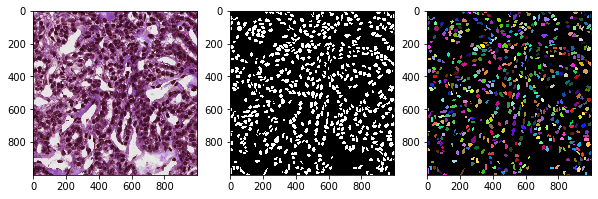

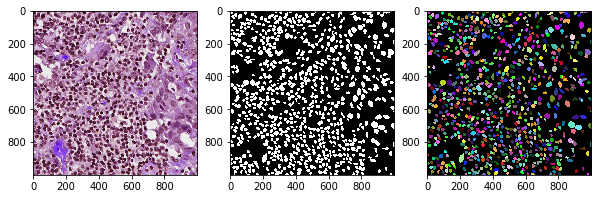

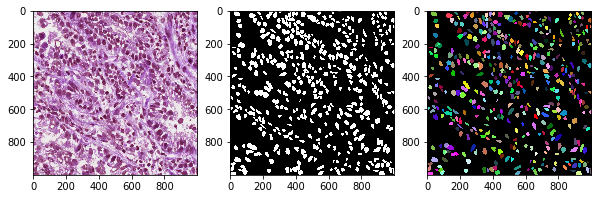

In [ ]:
#Using matplotlib subplots to plot in a table
for i in range (3):
    Image,Blackwhite,Color = ImagesTest[i],BWMTest[i],CMTest[i]
    fig,d =  plt.subplots(1,3)
    plt.rcParams["figure.figsize"] = (10,10)

    d[0].imshow(Image, interpolation='nearest')
    d[0].plot()

    d[1].imshow(Blackwhite, interpolation='nearest')
    d[1].plot()

    d[2].imshow(Color, interpolation='nearest')
    d[2].plot()
 #We have plotted the test image, its corresponding black and white and coloured masks here
 #Reference: https://www.w3schools.com/python/matplotlib_subplot.asp

In [ ]:
#Printing to make sure the shapes of the images and masks match, also to check the shape
print(ImagesTrain[1].shape)
print(BWMTrain[1].shape)

(1000, 1000, 3)
(1000, 1000, 3)


In [ ]:
#We want to create a larger dataset as 30 ismages is very low.
smalltrain=[]
smalltrainmask=[]
#We will do this by taking 20 random crops of size 256*256 from each training image
for j in range(30):
  for i in range(20):
    img=ImagesTrain[j]
    mask=BWMTrain[j]
    #Generating a arandom position, from where we will crop a window from both the image and its mask so that the mask matches the image
    x = np.random.randint(0, 1000 - 256)
    y = np.random.randint(0, 1000 - 256)
    #Cropping the image and mask at the required positions
    img = img[y:y+256, x:x+256]
    mask = mask[y:y+256, x:x+256]
    #Making a new dataset of smaller images
    smalltrain.append(img)
    smalltrainmask.append(mask)
#Reference: https://blog.roboflow.com/why-and-how-to-implement-random-crop-data-augmentation/

In [ ]:
#We want to create a larger dataset as 14 ismages is very low.
smalltest=[]
smalltestmask=[]
#We will do this by taking 20 random crops of size 256*256 from each test image
for j in range(14):
  for i in range(20):
    img=ImagesTest[j]
    mask=BWMTest[j]
    #Generating a arandom position, from where we will crop a window from both the image and its mask so that the mask matches the image
    x = np.random.randint(0, 1000 - 256)
    y = np.random.randint(0, 1000 - 256)
    #Cropping the image and mask at the required positions
    img = img[y:y+256, x:x+256]
    mask = mask[y:y+256, x:x+256]
    #Making a new dataset of smaller images
    smalltest.append(img)
    smalltestmask.append(mask)
#Reference: https://blog.roboflow.com/why-and-how-to-implement-random-crop-data-augmentation/

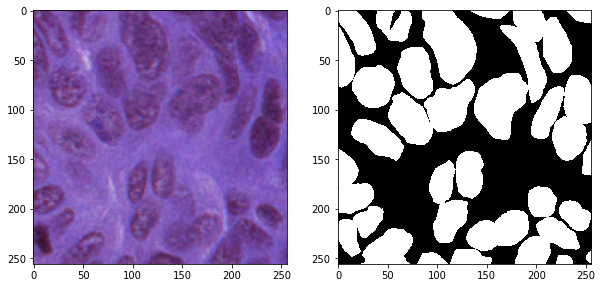

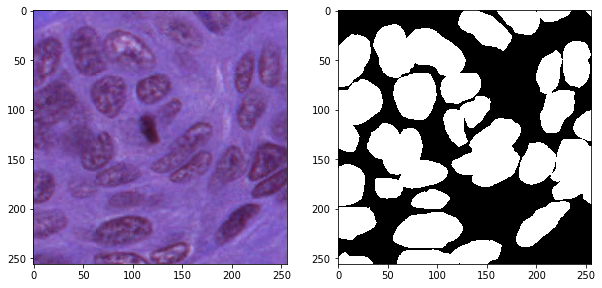

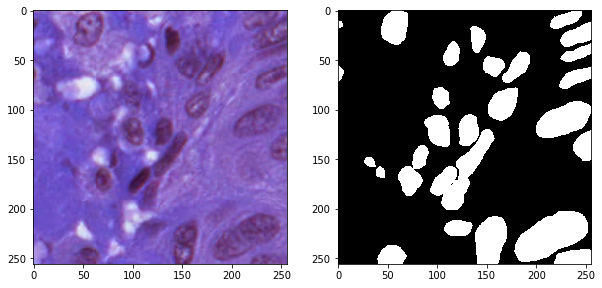

In [ ]:
#Displaying a few cropped training images and their black and white masks
for i in range (3):
    Image,Blackwhite = smalltrain[i],smalltrainmask[i]
    fig,d =  plt.subplots(1,2)
    plt.rcParams["figure.figsize"] = (10,10)

    d[0].imshow(Image, interpolation='nearest')
    d[0].plot()

    d[1].imshow(Blackwhite, interpolation='nearest')
    d[1].plot()


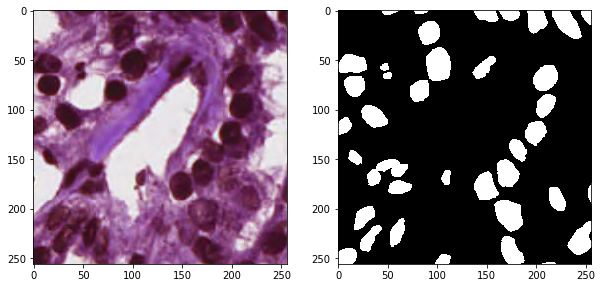

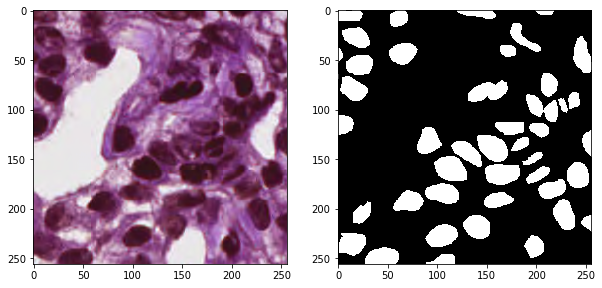

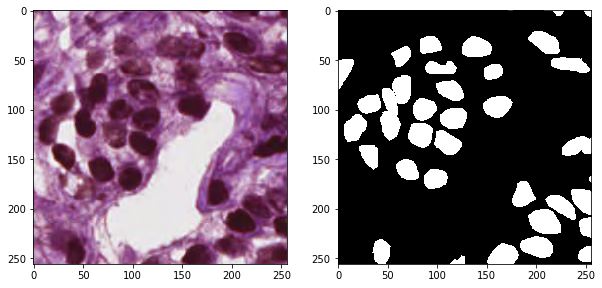

In [ ]:
#Displaying a few cropped test images and their black and white masks
for i in range (3):
    Image,Blackwhite = smalltest[i],smalltestmask[i]
    fig,d =  plt.subplots(1,2)
    plt.rcParams["figure.figsize"] = (10,10)

    d[0].imshow(Image, interpolation='nearest')
    d[0].plot()

    d[1].imshow(Blackwhite, interpolation='nearest')
    d[1].plot()


In [ ]:
#Printing the number of test and train images in the augmented dataset
print(len(smalltest))
print(len(smalltrain))

280
600


In [ ]:
#Splitting the test dataset into validation and test (from 280 images to 140 each)
smallval=smalltest[140:280]
smallvalmask=smalltestmask[140:280]
smalltest=smalltest[0:140]
smalltestmask=smalltestmask[0:140]
print(len(smalltest))
print(len(smallval))
print(len(smalltestmask))
print(len(smallvalmask))
#The masks were plot in the same way

140
140
140
140


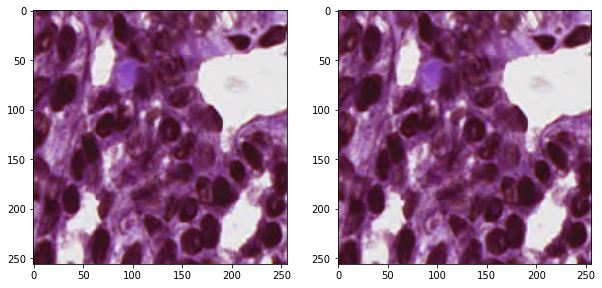

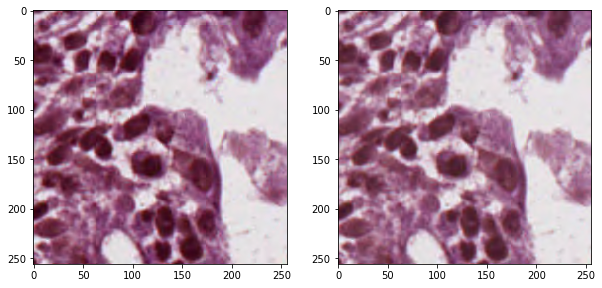

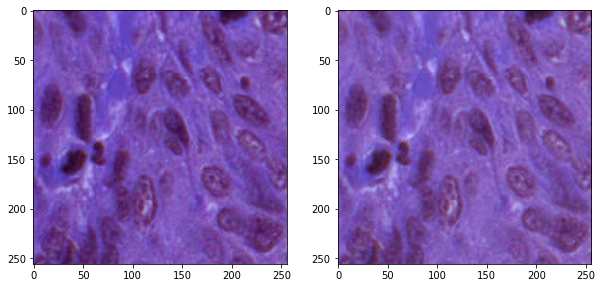

In [ ]:
#Making a new normalized dataset,
smalltestnorm=[]
smallvalnorm=[]
smalltrainnorm=[]
#For every test, train and validation image, we normalised the image using min max normalization.
#This helps in training, improves contrast and quality of image and brings the image pixels to values between 0 and 1
for i in range (140):
  smalltestnormimg= cv2.normalize(smalltest[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  smalltestnorm.append(smalltestnormimg)
  #displaying the normalized image vs the original image
  if (i==3):
    Norm,ori = smalltestnorm[i],smalltest[i]
    fig,d =  plt.subplots(1,2)
    plt.rcParams["figure.figsize"] = (10,10)
    d[0].imshow(Norm, interpolation='nearest')
    d[0].plot()
    d[1].imshow(ori, interpolation='nearest')
    d[1].plot()
#For every test, train and validation image, we normalised the image using min max normalization.
#This helps in training, improves contrast and quality of image and brings the image pixels to values between 0 and 1
for i in range (140):
  smallvalnormimg= cv2.normalize(smallval[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  smallvalnorm.append(smallvalnormimg)
  #displaying the normalized image vs the original image
  if (i==3):
    Norm,ori = smallvalnorm[i],smallval[i]
    fig,d =  plt.subplots(1,2)
    plt.rcParams["figure.figsize"] = (10,10)
    d[0].imshow(Norm, interpolation='nearest')
    d[0].plot()
    d[1].imshow(ori, interpolation='nearest')
    d[1].plot()
#For every test, train and validation image, we normalised the image using min max normalization.
#This helps in training, improves contrast and quality of image and brings the image pixels to values between 0 and 1
for i in range (600):
  smalltrainnormimg= cv2.normalize(smalltrain[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  smalltrainnorm.append(smalltrainnormimg)
  #displaying the normalized image vs the original image
  if (i==3):
    Norm,ori = smalltrainnorm[i],smalltrain[i]
    fig,d =  plt.subplots(1,2)
    plt.rcParams["figure.figsize"] = (10,10)
    d[0].imshow(Norm, interpolation='nearest')
    d[0].plot()
    d[1].imshow(ori, interpolation='nearest')
    d[1].plot()
#Reference: https://stackoverflow.com/questions/54666507/fast-image-normalisation-in-python

In [ ]:
#Creating a function to perform on the fly flips, rotations and colorjitter augmentations
def Augment(image,mask):
  #Horizonta and vertical flips of both image and mask, with probability half
  if np.random.random() < 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
  if np.random.random() < 0.5:
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)
  #Colorjitter augmentations for the network to work better on the H&E stained images
  image=image*255
  image=np.clip(img, a_min = 0, a_max = 255)
  pil_image=Image.fromarray(np.uint8(image))
  #Reference: https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html
  transform = transforms.ColorJitter(brightness=(0.5,1.5), contrast=(0.6,1.6), saturation=(0.7,1.7), hue=(-0.15,0.15))
  new= transform(pil_image)
  img = np.array(new)/255
  img=np.clip(img, a_min = 0, a_max = 255)
  #Multiplied and divided by 255 before and after colorjitter as normalized image has pixel values between 0 and 1
  #Clipped the image to avoid overflow
  return img,mask
  #This function was not used as the data was giving good results without extra augmentations, but it can be used for on the fly augmentations

In [ ]:
#Making a diceloss function using its formula for implementation in keras
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#This loss combines Dice loss with the standard binary cross-entropy (BCE) loss that is generally the default for segmentation models.
#Combining the two methods allows for some diversity in the loss, while benefitting from the stability of BCE.
#Dice Loss is widely used in medical image segmentation tasks to address the data imbalance problem.
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))



# Training without data normalization


Initially used the non-normalized data for training the model

In [ ]:
#Input image shape provided
inputs = Input((256,256,3))

#Wraps arbitrary expressions as a Layer object.
s = Lambda(lambda x: x / 255) (inputs)

#The downscaling layers have one convolutional layer, then a dropout layer,
#then another convolutional layer and the maxpooling to reduce the size of the image
#Five such blocks
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.1) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

#The lowermost layer has two convolutional layers and a dropout layer
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

#The upscaling layers have a convolutional layer, then the previous same size output is concatenated(a skip connection),
#then another convolutional layer, a dropout layer and another convolutional layer
#Five such blocks
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c5])
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)

u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u11)
c11 = Dropout(0.1) (c11)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c11)

#Using the sigmoid activation function in the final layer
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

#Compiling the model with adam optimizer, learning rate 0.0003, bce dice loss as the loss and dice loss as the metric
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.0003), loss=bce_dice_loss, metrics=[dice_loss])
model.summary()
# Reference: https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
 #Creating an array of training images and masks
 X_train=np.asarray(smalltrain)
 Y_train=np.asarray(smalltrainmask)
 #Converting the masks to a single channel
 Y_train=Y_train[:,:,:,1]/255

In [ ]:
#Creating an array of validation images and masks
 X_val=np.asarray(smallval)
 Y_val=np.asarray(smallvalmask)
#Converting the masks to a single channel
 Y_val=Y_val[:,:,:,1]/255

In [ ]:
#Printing and checking the shapes to make sure that they are right to be given to the model
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(600, 256, 256, 3)
(600, 256, 256)
(140, 256, 256, 3)
(140, 256, 256)


In [ ]:
#Early stopper function to stop the epochs if the validation loss does not improve for 5 consecutive epochs
earlystopper = EarlyStopping(monitor="val_loss",patience=5, verbose=1)
#Checkpointer function to save model checkpoints
checkpointer = ModelCheckpoint('msmol.h5', verbose=1, save_best_only=True)
#Fitting the model with the training data, batch size 8 and providing the validation dataset
history=model.fit(X_train,Y_train, batch_size=8, epochs=50, callbacks=[earlystopper,checkpointer],validation_data=(X_val,Y_val))

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.8323 - dice_loss: 0.5860
Epoch 1: val_loss improved from inf to 0.56498, saving model to msmol.h5
75/75 [==============================] - 24s 132ms/step - loss: 0.8323 - dice_loss: 0.5860 - val_loss: 0.5650 - val_dice_loss: 0.6838
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.6510 - dice_loss: 0.6914
Epoch 2: val_loss improved from 0.56498 to 0.49550, saving model to msmol.h5
75/75 [==============================] - 7s 98ms/step - loss: 0.6510 - dice_loss: 0.6914 - val_loss: 0.4955 - val_dice_loss: 0.7227
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.5988 - dice_loss: 0.7191
Epoch 3: val_loss improved from 0.49550 to 0.46731, saving model to msmol.h5
75/75 [==============================] - 7s 99ms/step - loss: 0.5988 - dice_loss: 0.7191 - val_loss: 0.4673 - val_dice_loss: 0.7378
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.5816 - dice_loss: 0.

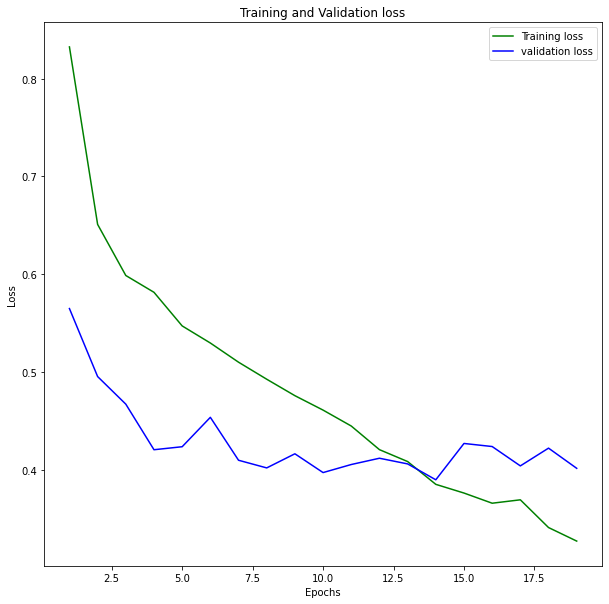

In [ ]:
#Plotting training and validation loss for every epoch
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#Training stopped after 19 epochs
epochs = range(1,20)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#Reference:https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

In [ ]:
#Saving the test data as a numpy array
X_test=np.asarray(smalltest)
Y_test=np.asarray(smalltestmask)
#Converting test masks to one channel
Y_test=Y_test[:,:,:,1]/255
from skimage.transform import resize
#Predicting the test images
preds_test = model.predict(X_test, verbose=1)
#If the probability value predicted is greater than 0.5, save the value as 1 (round up to integer)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (256,256),
                                       mode='constant', preserve_range=True))

5/5 [==============================] - 3s 321ms/step


In [ ]:
#Printing the test data shapes to check if they are okay
print(X_test.shape)
print(Y_test.shape)

(140, 256, 256, 3)
(140, 256, 256)


[]

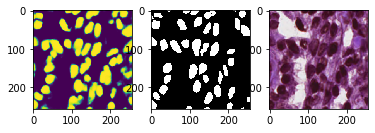

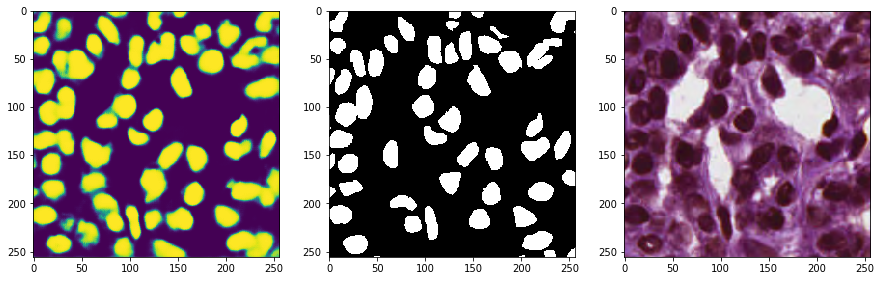

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
i=11
#Plottint the predictions, ground truths and original images in a table to compare
Pred,Ground,Img =preds_test_upsampled[i]*255,smalltestmask[i],smalltestnorm[i]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()
Pred,Ground,Img =preds_test_upsampled[12]*255,smalltestmask[12],smalltestnorm[12]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()

Results seem well segmented

# Training with data normalization


Same procedure as before but here we used the data that we had normalized instead of the original colour images

In [ ]:
#Input image shape provided
inputs = Input((256,256,3))

#Wraps arbitrary expressions as a Layer object.
s = Lambda(lambda x: x / 255) (inputs)

#The downscaling layers have one convolutional layer, then a dropout layer,
#then another convolutional layer and the maxpooling to reduce the size of the image
#Five such blocks
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.1) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

#The lowermost layer has two convolutional layers and a dropout layer
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

#The upscaling layers have a convolutional layer, then the previous same size output is concatenated(a skip connection),
#then another convolutional layer, a dropout layer and another convolutional layer
#Five such blocks
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c5])
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)

u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u11)
c11 = Dropout(0.1) (c11)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c11)

#Using the sigmoid activation function in the final layer
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

#Compiling the model with adam optimizer, learning rate 0.0003, bce dice loss as the loss and dice loss as the metric
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.0003), loss=bce_dice_loss, metrics=[dice_loss])
model.summary()
# Reference: https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_7 (Lambda)              (None, 256, 256, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv2d_161 (Conv2D)            (None, 256, 256, 16  448         ['lambda_7[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
#Using the normalized data for training
X_train=np.asarray(smalltrainnorm)
Y_train=np.asarray(smalltrainmask)
Y_train=Y_train[:,:,:,1]/255

In [ ]:
#Using the normalized data for validation
X_val=np.asarray(smallvalnorm)
Y_val=np.asarray(smallvalmask)
Y_val=Y_val[:,:,:,1]/255

In [ ]:
#Early stopper function to stop the epochs if the validation loss does not improve for 5 consecutive epochs
earlystopper = EarlyStopping(monitor="val_loss",patience=5, verbose=1)
#Checkpointer function to save model checkpoints
checkpointer = ModelCheckpoint('msmol.h5', verbose=1, save_best_only=True)
#Fitting the model with the training data, batch size 8 and providing the validation dataset
history=model.fit(X_train,Y_train, batch_size=8, epochs=50, callbacks=[earlystopper,checkpointer],validation_data=(X_val,Y_val))

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.9507 - dice_loss: 0.5222
Epoch 1: val_loss improved from inf to 0.69873, saving model to msmol.h5
75/75 [==============================] - 11s 121ms/step - loss: 0.9507 - dice_loss: 0.5222 - val_loss: 0.6987 - val_dice_loss: 0.6287
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.6812 - dice_loss: 0.6719
Epoch 2: val_loss improved from 0.69873 to 0.58607, saving model to msmol.h5
75/75 [==============================] - 8s 113ms/step - loss: 0.6812 - dice_loss: 0.6719 - val_loss: 0.5861 - val_dice_loss: 0.6653
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.6281 - dice_loss: 0.6984
Epoch 3: val_loss improved from 0.58607 to 0.52465, saving model to msmol.h5
75/75 [==============================] - 8s 109ms/step - loss: 0.6281 - dice_loss: 0.6984 - val_loss: 0.5246 - val_dice_loss: 0.7069
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.5988 - dice_loss: 

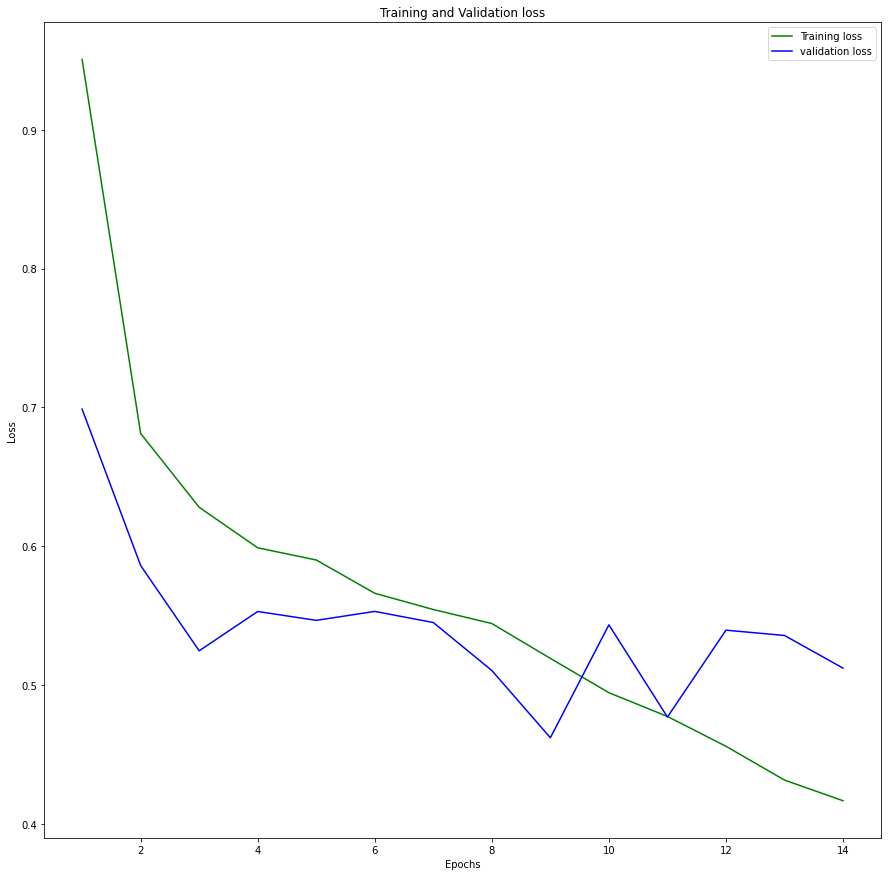

In [ ]:
#Plotting training and validation loss for every epoch
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#Model stopped training after 14 epochs
epochs = range(1,15)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#Reference:https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

In [ ]:
#creating the test arrays from the normalized images
X_test=np.asarray(smalltestnorm)
Y_test=np.asarray(smalltestmask)
#Converting test masks to one channel
Y_test=Y_test[:,:,:,1]/255
from skimage.transform import resize
#Predicting the test images
preds_test = model.predict(X_test, verbose=1)
#If the probability value predicted is greater than 0.5, save the value as 1 (round up to integer)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (256,256),
                                       mode='constant', preserve_range=True))

5/5 [==============================] - 1s 111ms/step


[]

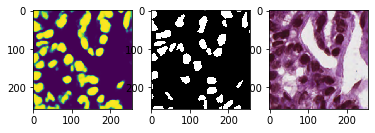

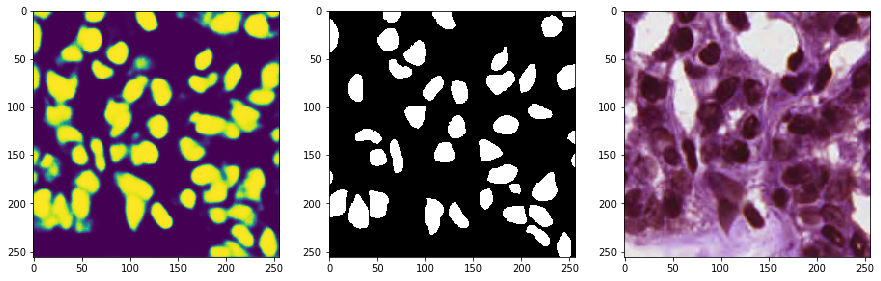

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
i=11
#Plotting the predictions, ground truths and original images in a table to compare
Pred,Ground,Img =preds_test_upsampled[i]*255,smalltestmask[i],smalltestnorm[i]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()
Pred,Ground,Img =preds_test_upsampled[12]*255,smalltestmask[12],smalltestnorm[12]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()


This gave a more blurry result than non normalised data.

Not normalizing seems to help give variety to the training images, helping them adapt to staining variability of H&E dye.

Should try colorjitter augmentations

# Training with fewer blocks

Same procedure as before, just by reducing the number of blocks used by the unet from 11 to 9 by removing one downscaling and one upscaling block

In [ ]:
#Input image shape provided
inputs = Input((256,256,3))

#Wraps arbitrary expressions as a Layer object.
s = Lambda(lambda x: x / 255) (inputs)

#The downscaling layers have one convolutional layer, then a dropout layer,
#then another convolutional layer and the maxpooling to reduce the size of the image
#Four such blocks
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

#The lowermost layer has two convolutional layers and a dropout layer
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

#The upscaling layers have a convolutional layer, then the previous same size output is concatenated(a skip connection),
#then another convolutional layer, a dropout layer and another convolutional layer
#Four such blocks
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

#Using the sigmoid activation function in the final layer
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

#Compiling the model with adam optimizer, learning rate 0.0003, bce dice loss as the loss and dice loss as the metric
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.0003), loss=bce_dice_loss, metrics=[dice_loss])
model.summary()
# Reference: https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_8 (Lambda)              (None, 256, 256, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv2d_184 (Conv2D)            (None, 256, 256, 16  448         ['lambda_8[0][0]']               
                                )                                                                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
 #Creating an array of training images and masks
 X_train=np.asarray(smalltrain)
 Y_train=np.asarray(smalltrainmask)
 #Converting the masks to a single channel
 Y_train=Y_train[:,:,:,1]/255

In [ ]:
#Creating an array of validation images and masks
 X_val=np.asarray(smallval)
 Y_val=np.asarray(smallvalmask)
#Converting the masks to a single channel
 Y_val=Y_val[:,:,:,1]/255

In [ ]:
#Early stopper function to stop the epochs if the validation loss does not improve for 5 consecutive epochs
earlystopper = EarlyStopping(monitor="val_loss",patience=5, verbose=1)
#Checkpointer function to save model checkpoints
checkpointer = ModelCheckpoint('msmol.h5', verbose=1, save_best_only=True)
#Fitting the model with the training data, batch size 8 and providing the validation dataset
history=model.fit(X_train,Y_train, batch_size=8, epochs=50, callbacks=[earlystopper,checkpointer],validation_data=(X_val,Y_val))

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.8926 - dice_loss: 0.5414
Epoch 1: val_loss improved from inf to 0.66208, saving model to msmol.h5
75/75 [==============================] - 9s 92ms/step - loss: 0.8926 - dice_loss: 0.5414 - val_loss: 0.6621 - val_dice_loss: 0.6223
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.6827 - dice_loss: 0.6717
Epoch 2: val_loss improved from 0.66208 to 0.61770, saving model to msmol.h5
75/75 [==============================] - 6s 85ms/step - loss: 0.6827 - dice_loss: 0.6717 - val_loss: 0.6177 - val_dice_loss: 0.6558
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.6429 - dice_loss: 0.6927
Epoch 3: val_loss did not improve from 0.61770
75/75 [==============================] - 7s 87ms/step - loss: 0.6429 - dice_loss: 0.6927 - val_loss: 0.6321 - val_dice_loss: 0.6552
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.6104 - dice_loss: 0.7076
Epoch 4: val_loss improved 

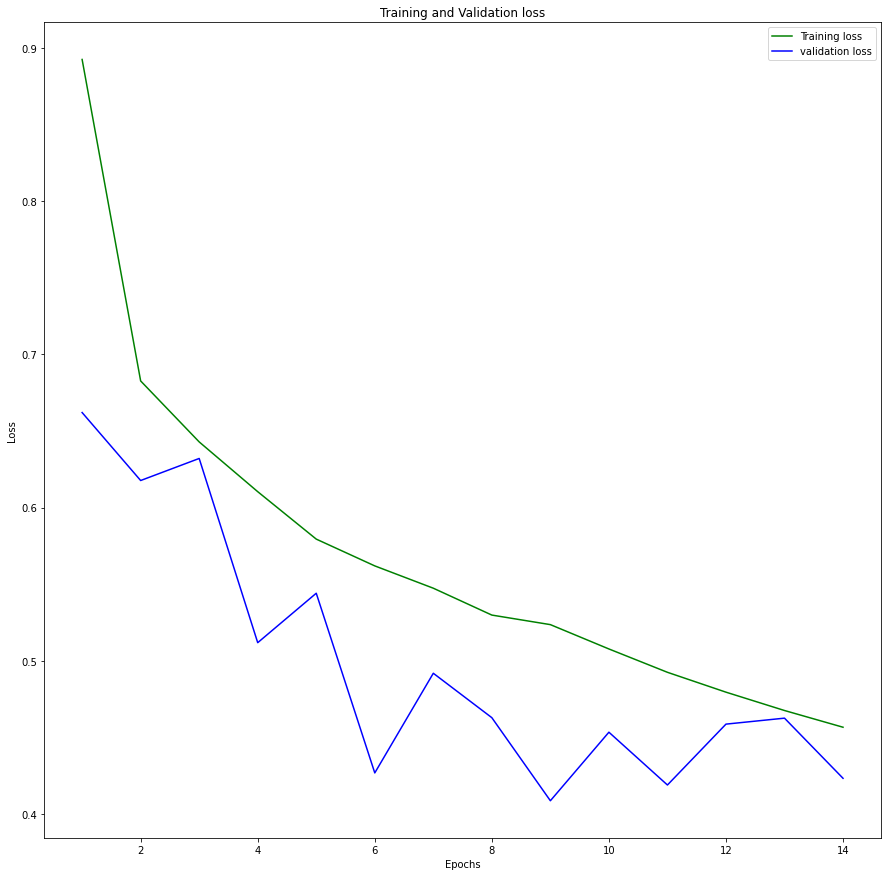

In [ ]:
#Plotting training and validation loss for every epoch
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#Training stopped after 14 epochs
epochs = range(1,15)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#Reference:https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

In [ ]:
#Saving the test data as a numpy array
X_test=np.asarray(smalltest)
Y_test=np.asarray(smalltestmask)
#Converting test masks to one channel
Y_test=Y_test[:,:,:,1]/255
from skimage.transform import resize
#Predicting the test images
preds_test = model.predict(X_test, verbose=1)
#If the probability value predicted is greater than 0.5, save the value as 1 (round up to integer)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (256,256),
                                       mode='constant', preserve_range=True))

5/5 [==============================] - 1s 99ms/step


[]

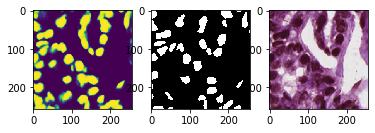

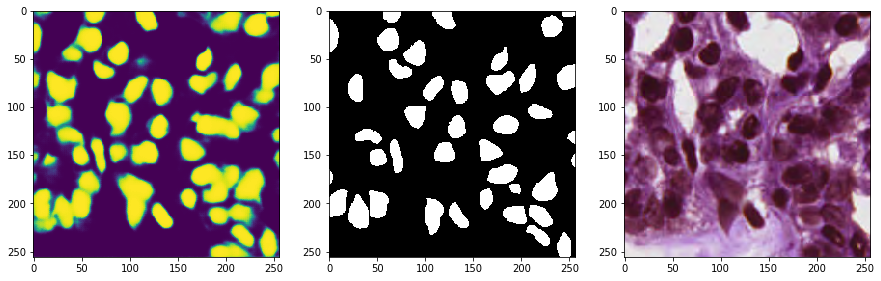

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
i=11
#Plotting the predictions, ground truths and original images in a table to compare
Pred,Ground,Img =preds_test_upsampled[i]*255,smalltestmask[i],smalltestnorm[i]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()
Pred,Ground,Img =preds_test_upsampled[12]*255,smalltestmask[12],smalltestnorm[12]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()

Some nuclei clubbed and some extra nuclei are present

# Training with fewer filters

Same procedure as before, just by reducing the number of filters used in each block of the unet

In [ ]:
#Input image shape provided
inputs = Input((256,256,3))

#Wraps arbitrary expressions as a Layer object.
s = Lambda(lambda x: x / 255) (inputs)

#The downscaling layers have one convolutional layer and the maxpooling to reduce the size of the image
#Five such blocks
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

#The lowermost layer has one convolutional layer
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)

#The upscaling layers have a convolutional layer, then the previous same size output is concatenated(a skip connection),
#then another convolutional layer
#Five such blocks
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c5])
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)


u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)

u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)


u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u11)

#Using the sigmoid activation function in the final layer
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

#Compiling the model with adam optimizer, learning rate 0.0003, bce dice loss as the loss and dice loss as the metric
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.0003), loss=bce_dice_loss, metrics=[dice_loss])
model.summary()
# Reference: https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_12 (Lambda)             (None, 256, 256, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv2d_251 (Conv2D)            (None, 256, 256, 16  448         ['lambda_12[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
 #Creating an array of training images and masks
 X_train=np.asarray(smalltrain)
 Y_train=np.asarray(smalltrainmask)
 #Converting the masks to a single channel
 Y_train=Y_train[:,:,:,1]/255

In [ ]:
#Creating an array of validation images and masks
 X_val=np.asarray(smallval)
 Y_val=np.asarray(smallvalmask)
#Converting the masks to a single channel
 Y_val=Y_val[:,:,:,1]/255

In [ ]:
#Early stopper function to stop the epochs if the validation loss does not improve for 5 consecutive epochs
earlystopper = EarlyStopping(monitor="val_loss",patience=5, verbose=1)
#Checkpointer function to save model checkpoints
checkpointer = ModelCheckpoint('msmol.h5', verbose=1, save_best_only=True)
#Fitting the model with the training data, batch size 8 and providing the validation dataset
history=model.fit(X_train,Y_train, batch_size=8, epochs=50, callbacks=[earlystopper,checkpointer],validation_data=(X_val,Y_val))

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.8870 - dice_loss: 0.5343
Epoch 1: val_loss improved from inf to 0.56675, saving model to msmol.h5
75/75 [==============================] - 6s 59ms/step - loss: 0.8870 - dice_loss: 0.5343 - val_loss: 0.5667 - val_dice_loss: 0.6580
Epoch 2/50
74/75 [============================>.] - ETA: 0s - loss: 0.6842 - dice_loss: 0.6653
Epoch 2: val_loss did not improve from 0.56675
75/75 [==============================] - 4s 51ms/step - loss: 0.6830 - dice_loss: 0.6660 - val_loss: 0.6013 - val_dice_loss: 0.6571
Epoch 3/50
74/75 [============================>.] - ETA: 0s - loss: 0.6251 - dice_loss: 0.6960
Epoch 3: val_loss improved from 0.56675 to 0.50943, saving model to msmol.h5
75/75 [==============================] - 4s 53ms/step - loss: 0.6239 - dice_loss: 0.6964 - val_loss: 0.5094 - val_dice_loss: 0.7050
Epoch 4/50
74/75 [============================>.] - ETA: 0s - loss: 0.5885 - dice_loss: 0.7181
Epoch 4: val_loss did not i

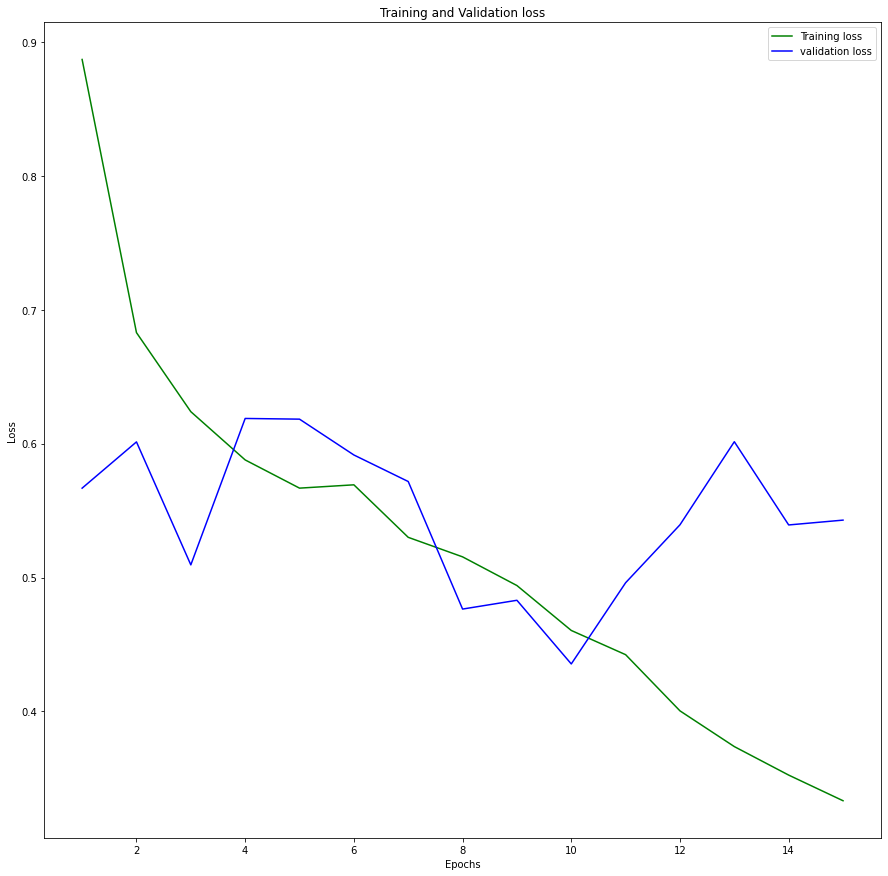

In [ ]:
#Plotting training and validation loss for every epoch
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#Training stopped after 15 epochs
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#Reference:https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

In [ ]:
#Saving the test data as a numpy array
X_test=np.asarray(smalltest)
Y_test=np.asarray(smalltestmask)
#Converting test masks to one channel
Y_test=Y_test[:,:,:,1]/255
from skimage.transform import resize
#Predicting the test images
preds_test = model.predict(X_test, verbose=1)
#If the probability value predicted is greater than 0.5, save the value as 1 (round up to integer)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (256,256),
                                       mode='constant', preserve_range=True))

5/5 [==============================] - 0s 64ms/step


[]

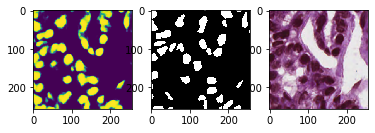

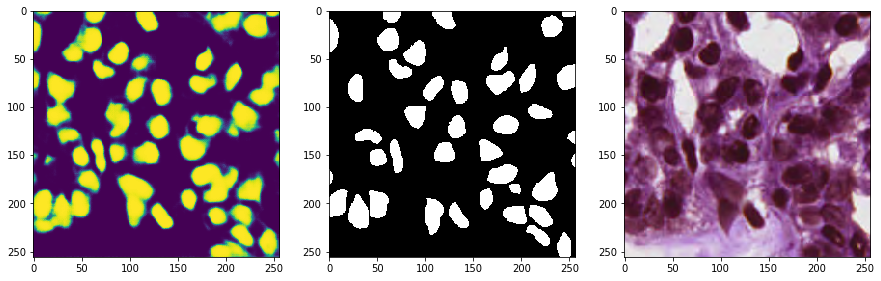

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
i=11
#Plottint the predictions, ground truths and original images in a table to compare
Pred,Ground,Img =preds_test_upsampled[i]*255,smalltestmask[i],smalltestnorm[i]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()
Pred,Ground,Img =preds_test_upsampled[12]*255,smalltestmask[12],smalltestnorm[12]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()

Well segmented nuclei, a few extra nuclei present though, seems better than reducing blocks

# Training with MS-SSIM_dice_loss

Same procedure as before, but using MSSIM combined with dice loss as the loss function instead of bce dice loss

The tensorflow MS-SSIM was giving resource exhausted errors, so we built a function by scratch and used it as the loss function

In [ ]:
# tf.image.ssim_multiscale(img1,img2,max_val=255,power_factors=0.1333,filter_size=11,filter_sigma=1.5,k1=0.01,k2=0.03)
#Making a diceloss function using its formula for implementation in keras
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mssimfunc(y_true,y_pred):
  #Means of two images
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  len=tf.size(y_true_f)
  lent=tf.cast(len, dtype=float)
  xbar, ybar = K.sum(y_true_f)/lent, K.sum(y_pred_f)/lent
  #Variances of the two images
  vara= K.sum((y_true_f-xbar)**2)/(lent - 1)
  varb= K.sum((y_pred_f-ybar)**2)/(lent - 1)
  #Covariance of the two images
  covar= K.sum((y_true_f-xbar)*(y_pred_f-ybar))/(lent - 1)
  ssim= 2*xbar*ybar*2*covar/((xbar**2+ybar**2)*(vara+varb))
  return ssim

#This loss combines Dice loss with the msssim loss that is generally the default for segmentation models.
def MSSIM_dice_loss(y_true, y_pred,a=0.5):
    return a*(1-mssimfunc(y_true,y_pred))+ (1-a)*(1 - dice_loss(y_true, y_pred))
# Reference: https://stackoverflow.com/questions/65013894/trade-off-between-losses

In [ ]:
#Input image shape provided
inputs = Input((256,256,3))

#Wraps arbitrary expressions as a Layer object.
s = Lambda(lambda x: x / 255) (inputs)

#The downscaling layers have one convolutional layer, then a dropout layer,
#then another convolutional layer and the maxpooling to reduce the size of the image
#Five such blocks
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.1) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

#The lowermost layer has two convolutional layers and a dropout layer
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

#The upscaling layers have a convolutional layer, then the previous same size output is concatenated(a skip connection),
#then another convolutional layer, a dropout layer and another convolutional layer
#Five such blocks
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c5])
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)

u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u11)
c11 = Dropout(0.1) (c11)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c11)

#Using the sigmoid activation function in the final layer
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

#Compiling the model with adam optimizer, learning rate 0.0003, mssim dice loss as the loss and dice loss as the metric
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.0003), loss=MSSIM_dice_loss, metrics=[dice_loss])
model.summary()
# Reference: https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_15 (Lambda)             (None, 256, 256, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv2d_199 (Conv2D)            (None, 256, 256, 16  448         ['lambda_15[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
 #Creating an array of training images and masks
 X_train=np.asarray(smalltrain)
 Y_train=np.asarray(smalltrainmask)
 #Converting the masks to a single channel
 Y_train=Y_train[:,:,:,1]/255

In [ ]:
#Creating an array of validation images and masks
 X_val=np.asarray(smallval)
 Y_val=np.asarray(smallvalmask)
#Converting the masks to a single channel
 Y_val=Y_val[:,:,:,1]/255

In [ ]:
#Early stopper function to stop the epochs if the validation loss does not improve for 5 consecutive epochs
earlystopper = EarlyStopping(monitor="val_loss",patience=5, verbose=1)
#Checkpointer function to save model checkpoints
checkpointer = ModelCheckpoint('msmol.h5', verbose=1, save_best_only=True)
#Fitting the model with the training data, batch size 8 and providing the validation dataset
history=model.fit(X_train,Y_train, batch_size=8, epochs=50, callbacks=[earlystopper,checkpointer],validation_data=(X_val,Y_val))

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.8364 - dice_loss: 0.6303
Epoch 1: val_loss improved from inf to 0.88518, saving model to msmol.h5
75/75 [==============================] - 11s 112ms/step - loss: 0.8364 - dice_loss: 0.6303 - val_loss: 0.8852 - val_dice_loss: 0.6268
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.6084 - dice_loss: 0.7269
Epoch 2: val_loss improved from 0.88518 to 0.64013, saving model to msmol.h5
75/75 [==============================] - 8s 106ms/step - loss: 0.6084 - dice_loss: 0.7269 - val_loss: 0.6401 - val_dice_loss: 0.7144
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.5698 - dice_loss: 0.7457
Epoch 3: val_loss improved from 0.64013 to 0.59456, saving model to msmol.h5
75/75 [==============================] - 8s 107ms/step - loss: 0.5698 - dice_loss: 0.7457 - val_loss: 0.5946 - val_dice_loss: 0.7357
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.5248 - dice_loss: 

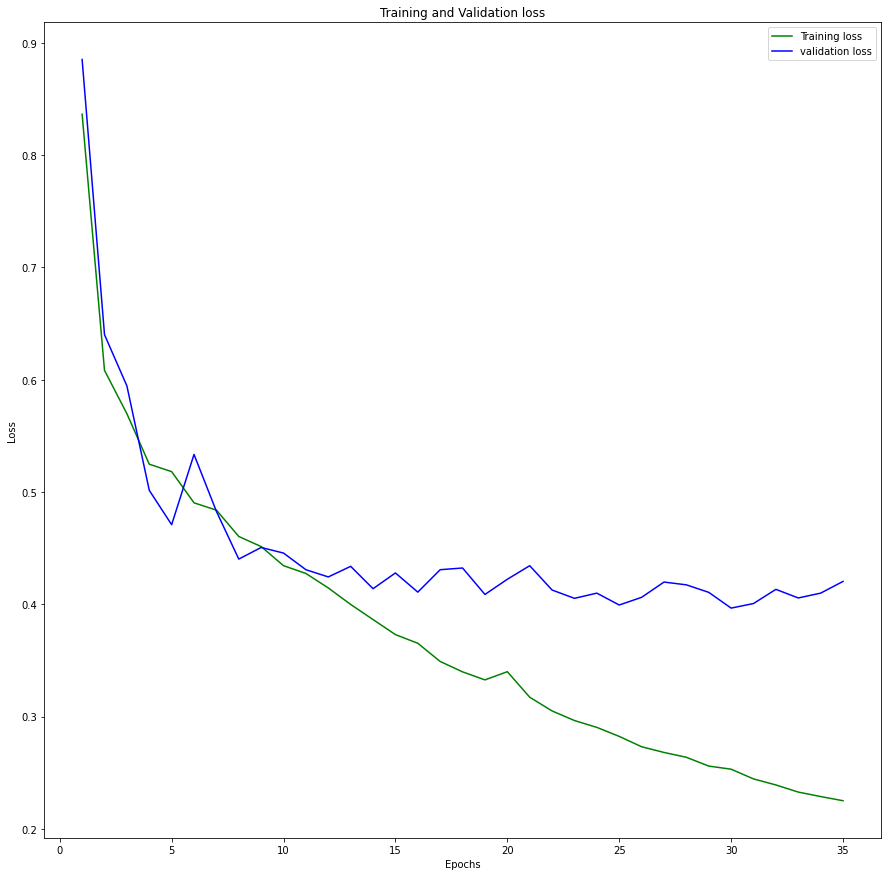

In [ ]:
#Plotting training and validation loss for every epoch
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#Training stopped after 35 epochs
epochs = range(1,36)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#Reference:https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

In [ ]:
#Saving the test data as a numpy array
X_test=np.asarray(smalltest)
Y_test=np.asarray(smalltestmask)
#Converting test masks to one channel
Y_test=Y_test[:,:,:,1]/255
from skimage.transform import resize
#Predicting the test images
preds_test = model.predict(X_test, verbose=1)
#If the probability value predicted is greater than 0.5, save the value as 1 (round up to integer)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (256,256),
                                       mode='constant', preserve_range=True))

5/5 [==============================] - 1s 97ms/step


[]

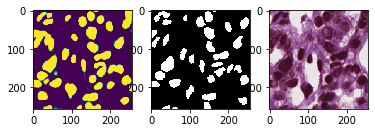

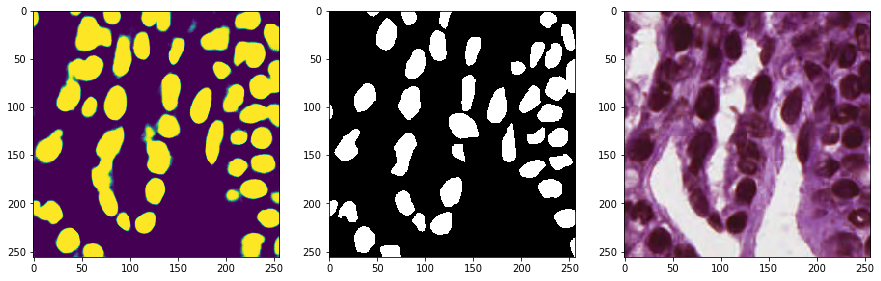

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
i=11
#Plotting the predictions, ground truths and original images in a table to compare
Pred,Ground,Img =preds_test_upsampled[i]*255,smalltestmask[i],smalltestnorm[i]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()
Pred,Ground,Img =preds_test_upsampled[12]*255,smalltestmask[12],smalltestnorm[12]
fig,d =  plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (15,15)
d[0].imshow(Pred, interpolation='nearest')
d[0].plot()
d[1].imshow(Ground, interpolation='nearest')
d[1].plot()
d[2].imshow(Img, interpolation='nearest')
d[2].plot()


MSSIM loss with dice loss gave crisp edges, and reduced the loss at a good rate leading to training for longer.

However, some of the nuclei have been clubbed into one

# Watershed Segmentation

In [ ]:
#Reference: https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
def watersheding(image):
  img=image.copy()
  #The cv2 functions used below require uint8 input (binary masks)
  img = img.astype("uint8")
  ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY)
  ## Defining kernel for opening operation
  kernel = np.ones((3,3), np.uint8)
  #Opening the binary mask
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
  ## After opening, will perform dilation
  sure_bg = cv2.dilate(opening, kernel, iterations=3)
  ## Sure background image
  opening = cv2.cvtColor(opening, cv2.COLOR_BGR2GRAY)
  sure_bg = cv2.cvtColor(sure_bg, cv2.COLOR_BGR2GRAY)
  #The cv2 functions used also require images to be in a single channel
  opening = opening.astype("uint8")
  #After opening we will also get the distance transform of the opened image
  dist_transform = cv2.distanceTransform(opening,distanceType=cv2.DIST_L2,maskSize=5)
  #Thresholding this distance transform again to get a sure foreground
  ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
  sure_fg = np.uint8(sure_fg)
  ## Sure foreground image
  minus_img = np.subtract(sure_bg, sure_fg)
  #The difference between the sure bg and sure fg
  ret, markers = cv2.connectedComponents(sure_fg)
  #generating markers to use in the watershed function
  markers = markers +1
  ## Add one so that sure background is not 1
  markers[minus_img == 255] = 0
  ## Making the unknown area as 0
  markers = cv2.watershed(img, markers)
  #Watershed segmentation
  img[markers == -1] = (255, 0, 0)
  ## boundary region is marked with -1
  return img, opening, sure_bg, minus_img
  #returning the sure bg, sure fg and their difference  and the watershed segmentation results

In [ ]:
lista=[]
listb=[]
listc=[]
listd=[]
#Making lists to store the watershed segmented image, the sure foreground, sure background and their difference
for i in range (140):
  im=np.zeros((256,256,3),float)
  #Converting the predicted image to a 3 channel image as that is what the watershed function takes as input
  im[:,:,0]=preds_test_upsampled[i]
  im[:,:,1]=preds_test_upsampled[i]
  im[:,:,2]=preds_test_upsampled[i]
  lista.append(watersheding(im)[0])
  listb.append(watersheding(im)[1])
  listc.append(watersheding(im)[2])
  listd.append(watersheding(im)[3])


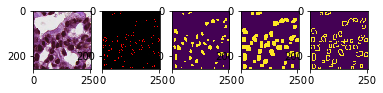

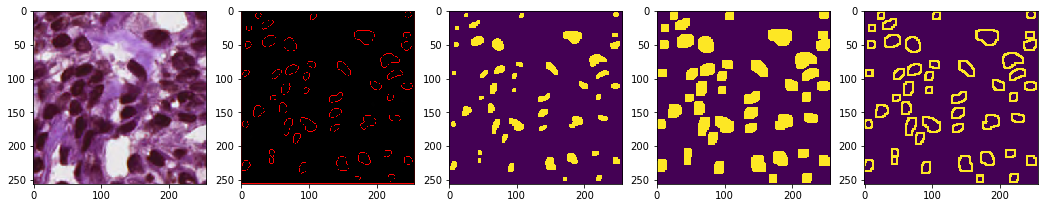

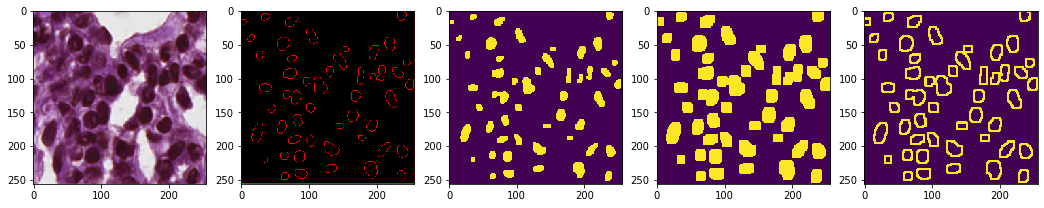

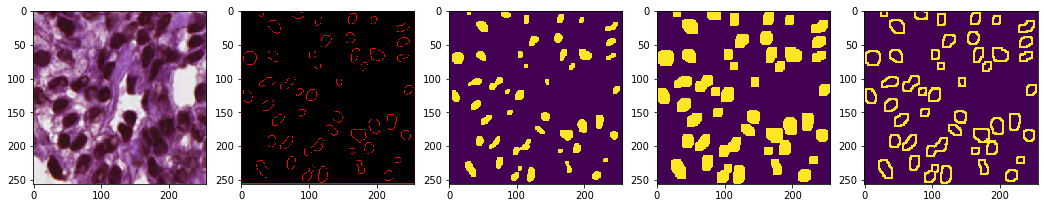

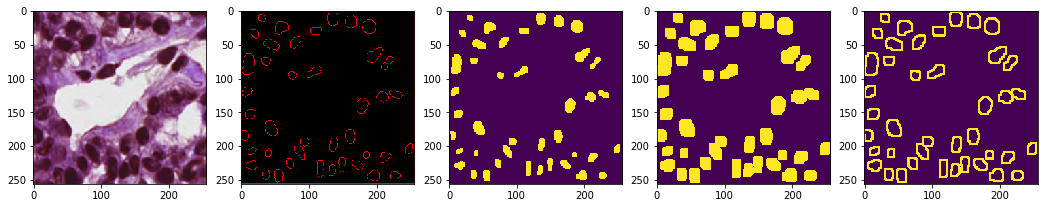

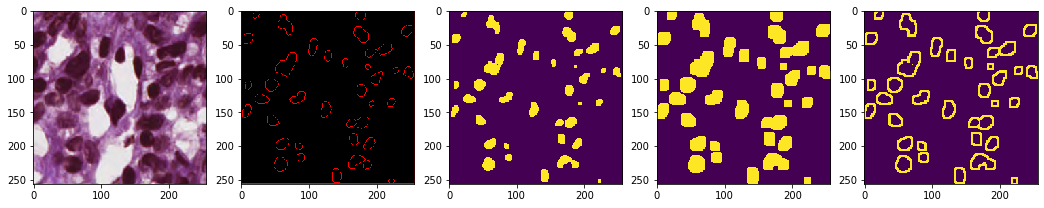

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
#Making a plot which shows the watershed segmented image, the sure foreground, sure background and their difference for a few images
for i in range (4,10):
  a,b,c,d= lista[i],listb[i],listc[i],listd[i]
  fig,d =  plt.subplots(1,5)
  plt.rcParams["figure.figsize"] = (18,18)
  d[0].imshow(X_test[i], interpolation='nearest')
  d[0].plot()
  d[1].imshow(a, interpolation='nearest')
  d[1].plot()
  d[2].imshow(b, interpolation='nearest')
  d[2].plot()
  d[3].imshow(c, interpolation='nearest')
  d[3].plot()
  d[4].imshow(c-b, interpolation='nearest')
  d[4].plot()

Successful watershed segmentation performed.

# References:

For the glob library: https://pynative.com/python-glob#:~:text=The%20glob%20module%2C%20part%20of,Unix%20Shell%20path%20expansion%20rules



For matplotlib subplots: https://www.w3schools.com/python/matplotlib_subplot.asp

For random crop data augmentations: https://blog.roboflow.com/why-and-how-to-implement-random-crop-data-augmentation/

For image normalization: https://stackoverflow.com/questions/54666507/fast-image-normalisation-in-python

For colorjitter augmentation: https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html

For the UNET model: https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

For plotting the train and validation losses: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

For mssim tradeoff: https://stackoverflow.com/questions/65013894/trade-off-between-losses

For watershed segmentation: https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html

# Alternative tries

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def gaussian(x, mu, sigma):
#     return np.exp(-(float(x) - float(mu)) ** 2 / (2 * sigma ** 2))


# def make_kernel(sigma):
#     # kernel radius = 2*sigma, but minimum 3x3 matrix
#     kernel_size = max(3, int(2 * 2 * sigma + 1))
#     mean = np.floor(0.5 * kernel_size)
#     kernel_1d = np.array([gaussian(x, mean, sigma) for x in range(kernel_size)])
#     # make 2D kernel
#     np_kernel = np.outer(kernel_1d, kernel_1d).astype(dtype=K.floatx())
#     # normalize kernel by sum of elements
#     kernel = np_kernel / np.sum(np_kernel)
#     kernel = np.reshape(kernel, (kernel_size, kernel_size, 1,1))    #height, width, in_channels, out_channel
#     return kernel

# def keras_SSIM_cs(y_true, y_pred):
#     axis=None
#     gaussian = make_kernel(1.5)
#     x = tf.nn.conv2d(y_true, gaussian, strides=[1, 1, 1, 1], padding='SAME')
#     y = tf.nn.conv2d(y_pred, gaussian, strides=[1, 1, 1, 1], padding='SAME')

#     u_x=K.mean(x, axis=axis)
#     u_y=K.mean(y, axis=axis)

#     var_x=K.var(x, axis=axis)
#     var_y=K.var(y, axis=axis)

#     cov_xy=K.cov(x, y, axis)

#     K1=0.01
#     K2=0.03
#     L=1  # depth of image (255 in case the image has a differnt scale)

#     C1=(K1*L)**2
#     C2=(K2*L)**2
#     C3=C2/2

#     l = ((2*u_x*u_y)+C1) / (K.pow(u_x,2) + K.pow(u_x,2) + C1)
#     c = ((2*K.sqrt(var_x)*K.sqrt(var_y))+C2) / (var_x + var_y + C2)
#     s = (cov_xy+C3) / (K.sqrt(var_x)*K.sqrt(var_y) + C3)

#     return [c,s,l]

# def keras_MS_SSIM(y_true, y_pred):
#     iterations = 5
#     x=y_true
#     y=y_pred
#     weight = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
#     c=[]
#     s=[]
#     for i in range(iterations):
#         cs=keras_SSIM_cs(x, y)
#         c.append(cs[0])
#         s.append(cs[1])
#         l=cs[2]
#         if(i!=4):
#             x=tf.image.resize_images(x, (x.get_shape().as_list()[1]//(2**(i+1)), x.get_shape().as_list()[2]//(2**(i+1))))
#             y=tf.image.resize_images(y, (y.get_shape().as_list()[1]//(2**(i+1)), y.get_shape().as_list()[2]//(2**(i+1))))
#     c = tf.stack(c)
#     s = tf.stack(s)
#     cs = c*s

#     #Normalize: suggestion from https://github.com/jorge-pessoa/pytorch-msssim/issues/2 last comment to avoid NaN values
#     l=(l+1)/2
#     cs=(cs+1)/2

#     cs=cs**weight
#     cs = tf.reduce_prod(cs)
#     l=l**weight[-1]

#     ms_ssim = l*cs
#     ms_ssim = tf.where(tf.is_nan(ms_ssim), K.zeros_like(ms_ssim), ms_ssim)

#     return K.mean(ms_ssim)


def mssimfunc(y_true,y_pred):
  # print(y_true.shape)
  # print(y_pred.shape)

  return tf.image.ssim_multiscale(y_true,y_pred,max_val=255.0, filter_size=2,filter_sigma=0)


def MSSIM_dice_loss(y_true, y_pred):
    return (1-mssimfunc(y_true,y_pred))+ (1 - dice_loss(y_true, y_pred))

In [ ]:
#Make loss function with mssim
#Computes the MS-SSIM between img1 and img2.
# tf.image.ssim_multiscale(img1,img2,max_val=255,power_factors=0.1333,filter_size=11,filter_sigma=1.5,k1=0.01,k2=0.03)
#Default values for filter size is 11 i.e. the size of gaussian filter, filter_sigma is 1.5 i.e. is the width of gaussian filter, for k1 it is 0.01 and k2 it is 0.03)
#OUTPUT:A tensor containing an MS-SSIM value for each image in batch. The values are in range [0, 1]. Returns a tensor with shape: broadcast(img1.shape[:-3], img2.shape[:-3]).
#reference https://www.tensorflow.org/api_docs/python/tf/image/ssim_multiscale

In [ ]:
inputs = Input((256,256,3))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
p3 = MaxPooling2D((2, 2)) (c3)


c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)



u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)


u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)


u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)


outputs = Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.0003), loss=MSSIM_dice_loss, metrics=[dice_loss])
model.summary()

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_50 (Lambda)             (None, 256, 256, 3)  0           ['input_51[0][0]']               
                                                                                                  
 conv2d_626 (Conv2D)            (None, 256, 256, 16  448         ['lambda_50[0][0]']              
                                )                                                                 
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
X_train=np.asarray(smalltrain)
Y_train=np.asarray(smalltrainmask)
Y_train=Y_train[:,:,:,1]/255

In [ ]:
X_val=np.asarray(smallval)
Y_val=np.asarray(smallvalmask)
Y_val=Y_val[:,:,:,1]/255

In [ ]:
print(Y_train[1].shape)

(256, 256)


In [ ]:
X_val=np.asarray(smallval)
Y_val=np.asarray(smallvalmask)


In [ ]:
print(X_train.shape)
print(Y_train.shape)

(600, 256, 256, 3)
(600, 256, 256)


In [ ]:
earlystopper = EarlyStopping(monitor="val_loss",patience=5, verbose=1)
checkpointer = ModelCheckpoint('msmol.h5', verbose=1, save_best_only=True)
history=model.fit(X_train,Y_train, batch_size=8, epochs=2)

Epoch 1/2


InvalidArgumentError: ignored

In [ ]:
# inputs = Input((256,256,3))

# s = Lambda(lambda x: x / 255) (inputs)

# c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
# p1 = MaxPooling2D((2, 2)) (c1)

# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
# p2 = MaxPooling2D((2, 2)) (c2)

# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
# p3 = MaxPooling2D((2, 2)) (c3)

# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
# p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

# c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)
# c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
# u7 = concatenate([u7, c5])
# c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)


# u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
# u8 = concatenate([u8, c4])
# c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)


# u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = concatenate([u9, c3])
# c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)


# u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
# u10 = concatenate([u10, c2])
# c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)


# u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
# u11 = concatenate([u11, c1], axis=3)
# c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u11)


# outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

# model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer=Adam(lr=0.0003), loss=MSSIM_dice_loss, metrics=[dice_loss])
# model.summary()